In [1]:
# Set imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import os 
import json
from torchmetrics import F1Score,JaccardIndex, Accuracy
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import numpy as np
from torchmetrics.classification import BinaryStatScores
import time
import cv2

# Import TuSimple loader
import sys
sys.path.insert(0,'../resources/')
from tusimple import TuSimple
import utils
from vit import ViT
from mlp_decoder import DecoderMLP



# ROOT DIRECTORIES
root_dir = os.path.dirname(os.getcwd())
annotated_dir = os.path.join(root_dir,'datasets/tusimple/train_set/annotations')
clips_dir = os.path.join(root_dir,'datasets/tusimple/train_set/')
annotated_dir_test = os.path.join(root_dir,'datasets/tusimple/test_set/annotations/')
test_clips_dir = os.path.join(root_dir,'datasets/tusimple/test_set/')


annotated = os.listdir(annotated_dir)


test_annotated = os.listdir(annotated_dir_test)



In [2]:
# Get path directories for clips and annotations for the TUSimple training  dataset + ground truth dictionary
# annotations = list()
# for gt_file in annotated:
#     path = os.path.join(annotated_dir,gt_file)
#     json_gt = [json.loads(line) for line in open(path)]
#     annotations.append(json_gt)
    
# annotations = [a for f in annotations for a in f]


# Get path directories for clips and annotations for the TUSimple test dataset + ground truth dictionary
test_annotations = list()
for gt_file in test_annotated:
    path = os.path.join(annotated_dir_test,gt_file)
    json_gt = [json.loads(line) for line in open(path)]
    test_annotations.append(json_gt)
    
test_annotations = [a for f in test_annotations for a in f]

test_dataset = TuSimple(train_annotations = test_annotations, train_img_dir = test_clips_dir, resize_to = (448,448), subset_size = 0.001, test = True, previous= 2)

In [3]:
# Adapted from : https://github.com/vinceecws/SegNet_PyTorch/blob/master/Pavements/SegNet.py

class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=1, BN_momentum=0.5):
        super(SegNet, self).__init__()
        
        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        self.lane_threshold = 0.5
        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)
        

    # Count pipeline trainable parameters
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
        
        x = F.local_response_norm(x, size=3)

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
         
        x, ind1 = self.MaxEn(x)
        size1 = x.size()


        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))
        
        x, ind3 = self.MaxEn(x)
        size3 = x.size()
        
        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
         
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
            
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)
        
        probs = F.sigmoid(x)
        
        return x,probs

    # Make a single prediction 
    def predict(self,x):
        self.eval()
        cnn_features,probs = self.forward(x)
        prediction = torch.where(probs > self.lane_threshold, torch.ones_like(probs), torch.zeros_like(probs))
        return prediction,cnn_features

    def canny_edge_detection_batch(self, x, low_threshold=50, high_threshold=150):
        batch_size, feature_dims, height, width = x.shape
        edges = []
        for i in range(batch_size):
            # Convert tensor to numpy array and transpose
            img = x[i].detach().cpu().permute(1, 2, 0).numpy()
        
            # Calculate mean of channels
            gray = np.mean(img, axis=2)

            # Apply Canny edge detection
            edges_img = cv2.Canny(gray.astype(np.uint8), low_threshold, high_threshold)
    
            # Convert back to tensor
            edges_img = torch.Tensor(edges_img).unsqueeze(0).unsqueeze(0)
        
            # Expand edge_feature_map to have the same number of channels as conv_feature_map
            edges_img = edges_img.repeat(1, feature_dims, 1, 1)
        
            edges.append(edges_img)
    
        edges = torch.cat(edges, dim=0)
    
        return edges
    
    # Predict with temporal post-processing
    def predict_temporal (self,x):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            for clip in x:
                base_frame = clip.to(device)
                # Predict mask probs for base frame
                _,base_mask_prob = self.forward(base_frame.unsqueeze(0))
            
                previous_masks = []
            
                # Predict masks probs for previous frames
                for i in range(1,len(x)):
                    prev_frame = x[i].to(device)
                    _,prev_mask = self.forward(prev_frame.unsqueeze(0))
                    previous_masks.append(prev_mask)
                
                # Define the decay factor for the previous frames weights
                decay_factor = 0.8

                # Calculate the weights for each previous frame
                weights = [decay_factor**i for i in range(len(clip[0])- 1)]
            
                # Normalize the weights so that they sum to 1
                weights /= np.sum(weights)

                # Loop over the previous frames and update the class probabilities for the target frame
                for i, prev_mask in enumerate(previous_masks):
                    weight = weights[i]
                    update_mask = (base_mask_prob < 0.85)
                    base_mask_prob[update_mask] = (1 - weight) * base_mask_prob[update_mask] + weight * prev_mask[update_mask]
                # # Loop over the previous frames and update the class probabilities for the target frame
                # for i, prev_mask in enumerate(previous_masks):
                #     weight = weights[i]
                #     base_mask_prob[:, 0, :, :] = (1 - weight) * base_mask_prob[:, 0, :, :] + weight * prev_mask[:, 0, :, :]
                
            prediction = torch.where(base_mask_prob > self.lane_threshold, torch.ones_like(base_mask_prob), torch.zeros_like(base_mask_prob))
            
        return prediction
            
    # Load trained model weights
    def load_weights(self,path): 
        self.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
        print('Loaded state dict succesfully!')

In [10]:
# Load dataset / Calculate pos weight
dataset = TuSimple(train_annotations = annotations, train_img_dir = clips_dir, resize_to = (448,448), subset_size = 0.001,val_size= 0.1)
train_set, validation_set = dataset.train_val_split()
del dataset

# Lane weight
pos_weight = utils.calculate_class_weight(train_set)

In [11]:
print(len(train_set))

2


In [4]:
# Evaluate on test set function (with temporal post-processing)
def evaluate(model, test_set):
    # Set up device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    f1_score = F1Score(task="binary").to(device)
    iou_score = JaccardIndex(task= 'binary').to(device)
    stat_scores = BinaryStatScores().to(device)
    accuracy = Accuracy(task="binary").to(device)
        
    test_f1 = 0
    test_iou = 0
    test_accuracy = 0
    fps_temp = 0
    
    
    no_temp_f1 = 0
    no_temp_iou = 0
    no_temp_accuracy = 0
    fps_no = 0
    
    all_stats_no = []
    all_stats_temp = []
    
    model.eval()
    with torch.no_grad():
        for clip in test_set:
            gt = clip[1].to(device)
            base_frame = clip[0][0].to(device)
            
            start_time1 = time.time()
            
            start_time2 = time.time()
            
            # Predict mask probs for base frame
            _,base_mask_prob = model.forward(base_frame.unsqueeze(0))
            
            end_time1 = time.time()
            
            # Get F1 scores,IoU and Accuracy before temporal post process
            no_temp_f1 += f1_score(base_mask_prob.to(device), gt.unsqueeze(0))
            no_temp_iou += iou_score(base_mask_prob.to(device), gt.unsqueeze(0))
            no_temp_accuracy += accuracy(base_mask_prob.to(device), gt.unsqueeze(0))
            
            # Measure FPS without temporal post process
            processing_time = end_time1 - start_time1
            fps_no += (1 / processing_time)
            
            # Get stats to calculate FPR/FNR
            all_stats_no.append(stat_scores(base_mask_prob.to(device), gt.unsqueeze(0)))
            
            previous_masks = []
            
            # Predict masks probs for previous frames
            for i in range(1,len(clip[0])):
                prev_frame = clip[0][i].to(device)
                _,prev_mask = model.forward(prev_frame.unsqueeze(0))
                previous_masks.append(prev_mask)
            
            # Define the decay factor for the previous frames weights
            decay_factor = 0.8

            # Calculate the weights for each previous frame
            weights = [decay_factor**i for i in range(len(clip[0])- 1)]
            
            # Normalize the weights so that they sum to 1
            weights /= np.sum(weights)
            
            
            # Loop over the previous frames and update the class probabilities for the target frame
            for i, prev_mask in enumerate(previous_masks):
                weight = weights[i]
                base_mask_prob[:, 0, :, :] = (1 - weight) * base_mask_prob[:, 0, :, :] + weight * prev_mask[:, 0, :, :]
                
            end_time2 = time.time()
            
            # Measure FPS with temporal post process
            processing_time = end_time2 - start_time2
            fps_temp += (1 / processing_time)
            
            # Compare new mask with temporal post process with gt and get evaluation scores
            test_f1 += f1_score(base_mask_prob.to(device), gt.unsqueeze(0))
            test_iou += iou_score (base_mask_prob.to(device), gt.unsqueeze(0))
            test_accuracy += accuracy(base_mask_prob.to(device), gt.unsqueeze(0))
            
            # Get stats for FNR/FPR with temporal
            all_stats_temp.append(stat_scores(base_mask_prob.to(device), gt.unsqueeze(0)))
            
        # Get FPR and FNR for test set (with and without temporal)
        
        fp1_sum = torch.stack([s[1] for s in all_stats_no]).sum()
        fn1_sum = torch.stack([s[3] for s in all_stats_no]).sum()
        tn1_sum = torch.stack([s[2] for s in all_stats_no]).sum()
        tp1_sum = torch.stack([s[0] for s in all_stats_no]).sum()
        
        # Average fpr without temporal
        fpr_no = fp1_sum / (tn1_sum + fp1_sum)
        fnr_no = fn1_sum / (tp1_sum + fn1_sum)
        
        fp2_sum = torch.stack([s[1] for s in all_stats_temp]).sum()
        fn2_sum = torch.stack([s[3] for s in all_stats_temp]).sum()
        tn2_sum = torch.stack([s[2] for s in all_stats_temp]).sum()
        tp2_sum = torch.stack([s[0] for s in all_stats_temp]).sum()
        
        # Average fpr and fnr with temporal
        fpr_temp = fp2_sum / (tn2_sum + fp2_sum)
        fnr_temp = fn2_sum / (tp2_sum + fn2_sum)
        
        # Calculate test set average metrics
        test_f1 /= len(test_set)
        test_iou /= len(test_set)
        no_temp_f1 /= len(test_set)
        no_temp_iou /= len(test_set)
        no_temp_accuracy /= len(test_set)
        test_accuracy /= len(test_set)
        fps_temp /= len(test_set)
        fps_no /= len(test_set)
        
        # Create lists of metrics with and without temporal post process
        
        without = [round(fpr_no.item(),4), round(fnr_no.item(),4), round(no_temp_f1.item(),3), round(no_temp_iou.item(),3), round(no_temp_accuracy.item(),3) * 100, round(float(fps_no),3)]
        
        temporal = [round(fpr_temp.item(),4), round(fnr_temp.item(),4), round(test_f1.item(),3), round(test_iou.item(),3),round(test_accuracy.item(),3) * 100 ,round(float(fps_temp),3)]
        
        return without,temporal
            

# Plot metrics function 
def plot_metrics(train_losses, val_losses, train_f1, val_f1, train_iou, val_iou):
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation')
    plt.xlabel('Epochs (bins of 5)')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(train_losses) + 1, 5))
    plt.legend()
    plt.show()

    # Plot training and validation F1 scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_f1) + 1), train_f1, label='Train')
    plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation')
    plt.xlabel('Epochs (bins of 5)')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, len(train_f1) + 1, 5))
    plt.legend()
    plt.show()

    # Plot training and validation IoU scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_iou) + 1), train_iou, label='Train')
    plt.plot(range(1, len(val_iou) + 1), val_iou, label='Validation')
    plt.xlabel('Epochs (bins of 5)')
    plt.ylabel('IoU Score')
    plt.xticks(range(0, len(train_iou) + 1, 5))
    plt.legend()
    plt.show()

# Custom training function for the pipeline with schedule and augmentations
def train(model, train_loader, val_loader = None, num_epochs=10, lr=0.01, weight_decay=0, SGD_momentum = 0.9, lr_scheduler=False, lane_weight = None):
    # Set up loss function and optimizer
    criterion =  nn.BCEWithLogitsLoss(pos_weight= lane_weight)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=SGD_momentum, weight_decay=weight_decay)

    # Set up learning rate scheduler
    if lr_scheduler:
        pass

    # Set up device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    f1_score = F1Score(task="binary").to(device)
    iou_score = JaccardIndex(task= 'binary').to(device)
    
    gt_augmentations = transforms.Compose([transforms.RandomRotation(degrees=(10, 30)),
                                              transforms.RandomHorizontalFlip()])
  
    train_augmentations = transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
                                            transforms.ColorJitter(brightness=0.35, contrast=0.2, saturation=0.4, hue=0.1)])
    # Set a seed for augmentations
    torch.manual_seed(42) 
    
    # Metrics collection for plotting
    train_losses = []
    train_f1_scores = []
    train_iou_scores = []
    
    val_losses = []
    val_f1_scores = []
    val_iou_scores = []
    
    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0
        train_iou = 0
        train_f1 = 0
        
        val_iou = 0
        val_f1 = 0
        val_loss = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            model.train()
            # Combine the inputs and targets into a single tensor
            data = torch.cat((inputs, targets), dim=1)
            # Apply the same augmentations to the combined tensor
            augmented_data = gt_augmentations(data)    
    
            # Split the augmented data back into individual inputs and targets
            inputs = augmented_data[:, :inputs.size(1)]
            targets = augmented_data[:, inputs.size(1):].to(device)

            inputs = train_augmentations(inputs).to(device)
      
            optimizer.zero_grad()
            outputs, eval_out = model(inputs)

            loss = criterion(outputs.to(device), targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            train_iou += iou_score(eval_out.to(device).detach(), targets)
            train_f1 += f1_score(eval_out.to(device).detach(),targets)
        
        if val_loader:
            model.eval()
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(val_loader): 
                
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits,outputs = model(inputs)
                    
                    
                    val_loss = criterion(logits.to(device),targets)
                    val_loss += val_loss.item() * inputs.size(0)
                    
                    val_iou += iou_score(outputs.to(device), targets)
                    val_f1 += f1_score(outputs.to(device),targets)

                val_loss /= len(val_loader)
                val_iou /= len(val_loader)
                val_f1 /= len(val_loader)
            
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_f1 /= len(train_loader)
    
    
    
        # Collect metrics for plotting
        train_losses.append(train_loss)
        train_f1_scores.append(train_f1)
        train_iou_scores.append(train_iou)
    
        if val_loader:
            val_losses.append(val_loss)
            val_f1_scores.append(val_f1)
            val_iou_scores.append(val_iou)
        
        
     # Print progress
        if lr_scheduler:
            print('Epoch: {} - Train Loss: {:.4f} - Learning Rate: {:.6f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss,optimizer.param_groups[0]['lr'], train_iou, train_f1))
            # scheduler.step()
            if val_loader:
                print('Val_F1: {:.5f}  - Val_IoU: {:.5f} '.format(val_f1,val_iou))
        else:
            print('Epoch: {} - Train Loss: {:.4f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss, train_iou, train_f1))
            
            if val_loader:
                print('Val_Loss: {} - Val_F1: {:.5f}  - Val_IoU: {:.5f} '.format(val_loss,val_f1,val_iou))
    
    if val_loader:
        return train_losses,train_f1_scores,train_iou_scores,val_losses,val_f1_scores,val_iou_scores
    else:
        return train_losses,train_f1_scores,train_iou_scores

In [5]:
model = SegNet()
print(f'Number of trainable parameters : {model.count_parameters()}')
model.load_weights('../models/best_segnet.pth')

Number of trainable parameters : 29443587
Loaded state dict succesfully!


In [ ]:
# Greek road video
import cv2

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (448, 448)) # replace with the size of your input image
    image = image.astype(np.float32) / 255.0
    return image


def make_video(frames_dir, output_file):
    
    # get the list of frame filenames
    frame_filenames = [f for f in os.listdir(frames_dir) if f.endswith('.jpg') or f.endswith('.png')]
    # sort the filenames based on the integer value of the filename
    frame_filenames = sorted(frame_filenames, key=lambda x: int(x.split(".")[0]))

    # get the first frame to use as a reference for the video dimensions
    first_frame_path = os.path.join(frames_dir, frame_filenames[0])
    first_frame = cv2.imread(first_frame_path)
    height, width, channels = first_frame.shape
    
    video_length = len(frame_filenames) * 0.1
    fps = len(frame_filenames) / video_length

    # initialize the video writer object
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_file, fourcc, fps , (width, height))
    
    # loop over the frames directory and process each frame
    for filename in frame_filenames:
        image_path = os.path.join(frames_dir, filename)
        image = cv2.imread(image_path)

        # write the image with the predicted lane points overlaid to the video
        video_writer.write(image)

    # release the video writer object
    video_writer.release()


frames_dir = '../clips/good_lanes_clip'

frames_list = os.listdir(frames_dir)
# sort the filenames based on the integer value of the filename
frames_list = sorted(frames_list, key=lambda x: int(x.split(".")[0]))
print(frames_list)
no_prev = 2


# loop over the frames directory and process each frame
for filename in frames_list:
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        frame_id = frames_list.index(filename)

        # load the image
        image_path = os.path.join(frames_dir, filename)
        image = torch.from_numpy(load_image(image_path).transpose(2,0,1))
        
        if frame_id >= no_prev:
            previous_frames = []
            previous_frames.append(image)
            for i in range (frame_id - 1,(frame_id - no_prev) - 1, -1):
                previous_fname = frames_list[i]
                previous_path = os.path.join(frames_dir, filename)
                previous = torch.from_numpy(load_image(image_path).transpose(2,0,1))
                previous_frames.append(previous)
                
            pred = model.predict_temporal(previous_frames)
            mask = pred.squeeze(0).detach().cpu().numpy()
       
            # convert the binary mask to green dots on the original frame
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            green_dots = np.zeros_like(original_image)
            green_dots[:,:,1] = 255 * mask
            overlay_image = cv2.addWeighted(original_image, 0.7, green_dots, 0.3, 0)

            # save the image with green masked predicted lane points 
            cv2.imwrite(f'../clips/pred_frames/{filename}', overlay_image)
        
        else:
            
            pred,_ = model.predict(image.unsqueeze(0))
            mask = pred.squeeze(0).cpu().numpy()
       
            # convert the binary mask to green dots on the original frame
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            green_dots = np.zeros_like(original_image)
            green_dots[:,:,1] = 255 * mask
            overlay_image = cv2.addWeighted(original_image, 0.7, green_dots, 0.3, 0)

            # save the image with green masked predicted lane points 
            cv2.imwrite(f'../clips/pred_frames/{filename}', overlay_image)
                
            
            


In [44]:
# Predicted marked frames dir
pred_frames_dir = '../clips/pred_frames'
output_file = '../clips/pred_vid_good_temp.mp4'
make_video(pred_frames_dir, output_file)

In [19]:
without, temporal = evaluate(model,test_dataset)

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
# Create dataloaders for train and validation 
train_loader = DataLoader(train_set, batch_size= 2,shuffle= True, drop_last= True, num_workers= 4) 
validation_loader = DataLoader(validation_set,batch_size= 2, shuffle= True, drop_last= True, num_workers= 4) 

In [ ]:
# Train the model
train_losses,train_f1_scores,train_iou_scores,val_losses,val_f1_scores,val_iou_scores = train(model, train_loader,val_loader= validation_loader , num_epochs= 2, 
                                                                                        lane_weight = pos_weight, lr = 0.01, SGD_momentum= 0.9)

In [ ]:
# Plot metrics after training for train and validation sets (bins of 5 epochs)
plot_metrics(train_losses,val_losses,train_f1_scores,val_f1_scores,train_iou_scores,val_iou_scores)

In [8]:
img_tns,gt = validation_set[0]

model.eval()
test_pred, test_features = model.predict(img_tns.unsqueeze(0))

test_pred = test_pred.squeeze(0)
test_features = test_features.squeeze(0)
print(test_pred.shape,test_features.shape)

torch.Size([1, 448, 448]) torch.Size([1, 448, 448])


/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
print(len(test_dataset))

2


In [7]:
pred = model.predict_temporal(test_dataset[1][0]).squeeze(0)

In [8]:
pred.shape

torch.Size([1, 448, 448])

In [161]:
utils.disp_img(utils.toImagearr(pred), name = 'Prediction')

In [57]:
utils.disp_img(utils.toImagearr(test_dataset[1][0][0]))

In [ ]:
    # # Plot the clustering results with one line passing from each cluster center
    # fig, ax = plt.subplots(figsize=(8, 8))
    # ax.scatter(points[:,0], points[:,1], c=labels, cmap='viridis')

    # # Plot a line for each cluster center
    # for center in cluster_centers:
    #     angle = np.arctan2(center[1], center[0])
    #     rho = center[0]*np.cos(angle) + center[1]*np.sin(angle)
    #     x = np.linspace(-1000, 1000, 2)
    #     y = (rho - x*np.cos(angle))/np.sin(angle)
    #     ax.plot(x,y, c='r', linewidth=2)

    # ax.axis('equal')
    # plt.show()
    


Labels:  [0 0 1 0 1 1 1 1 0 2 1 2 2 1]
Cluster centers:  [array([271.5      ,   0.4537856], dtype=float32), array([-71.14286 ,   2.435981], dtype=float32), array([39.333332 ,  2.0362175], dtype=float32)]


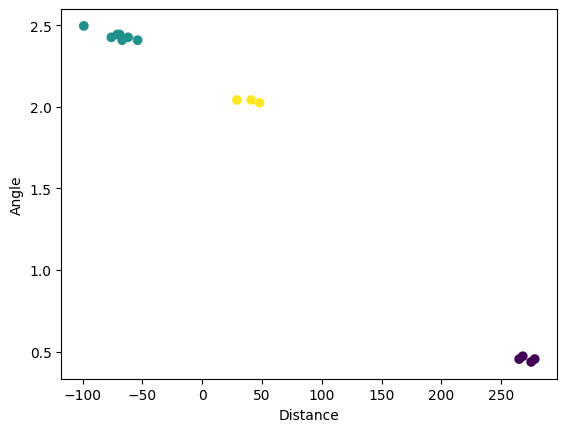

1


In [173]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN

def post_process_segmentation_output(segmentation_output):
    # Apply Canny edge detection
    edges = cv2.Canny(segmentation_output.astype(np.uint8), 100, 200)
    
    utils.disp_img(edges)

    lines = cv2.HoughLines(edges,rho = 1, theta=np.pi/180, threshold = 80)
    
    # Create a black image with the same size as the original image
    disp_lines = np.zeros_like(segmentation_output)

    # Draw each line on the mask
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(disp_lines, (x1, y1), (x2, y2), 255, 1)

    # Display the binary mask
    utils.disp_img(disp_lines)
    
    points = lines.squeeze()
    
    # Perform mean shift clustering
    dbs = DBSCAN(eps=25, min_samples=3)
    # Fit the model and get the labels
    labels = dbs.fit_predict(points)

    # Get the unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Compute the mean of each cluster to get the cluster centers
    cluster_centers = []
    for label in unique_labels:
        if label == -1:
            continue
        cluster_center = np.mean(points[labels == label], axis=0)
        cluster_centers.append(cluster_center)
        
    # Print the labels and cluster centers
    print("Labels: ", labels)
    print("Cluster centers: ", cluster_centers)

    # Plot the mean shift clustering results
    plt.scatter(points[:,0], points[:,1], c=labels, cmap='viridis')
    plt.xlabel('Distance')
    plt.ylabel('Angle')
    plt.show()
    
    # Convert cluster centers to Cartesian coordinates
    cart_centers = []
    for center in cluster_centers:
        rho = center[0]
        theta = center[1]
        x = rho * np.cos(theta)
        y = rho * np.sin(theta)
        cart_centers.append((x, y))
    return 1
    
        


    
vp = post_process_segmentation_output(utils.toImagearr(pred))